In [2]:
import optuna
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install kaleido
!pip install nbformat

## Optuna plots

In [2]:
fname = './study_best_model.pkl'
with open(fname, 'rb') as f:
    study = pickle.load(f)
os.makedirs('optuna-vis', exist_ok=True)


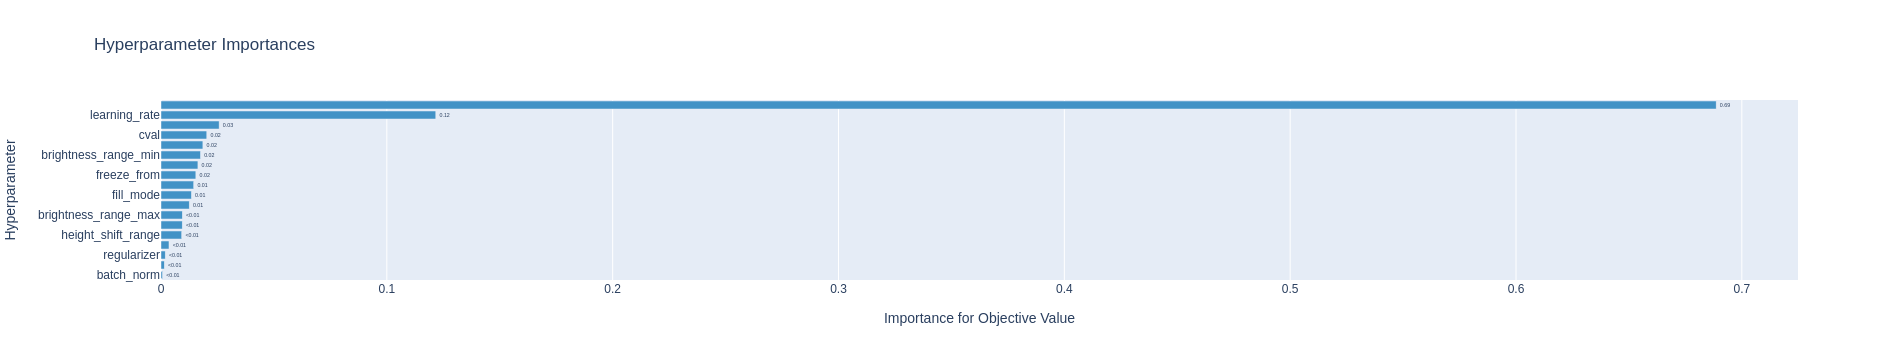

In [16]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image('./optuna-vis/importance.png')
fig

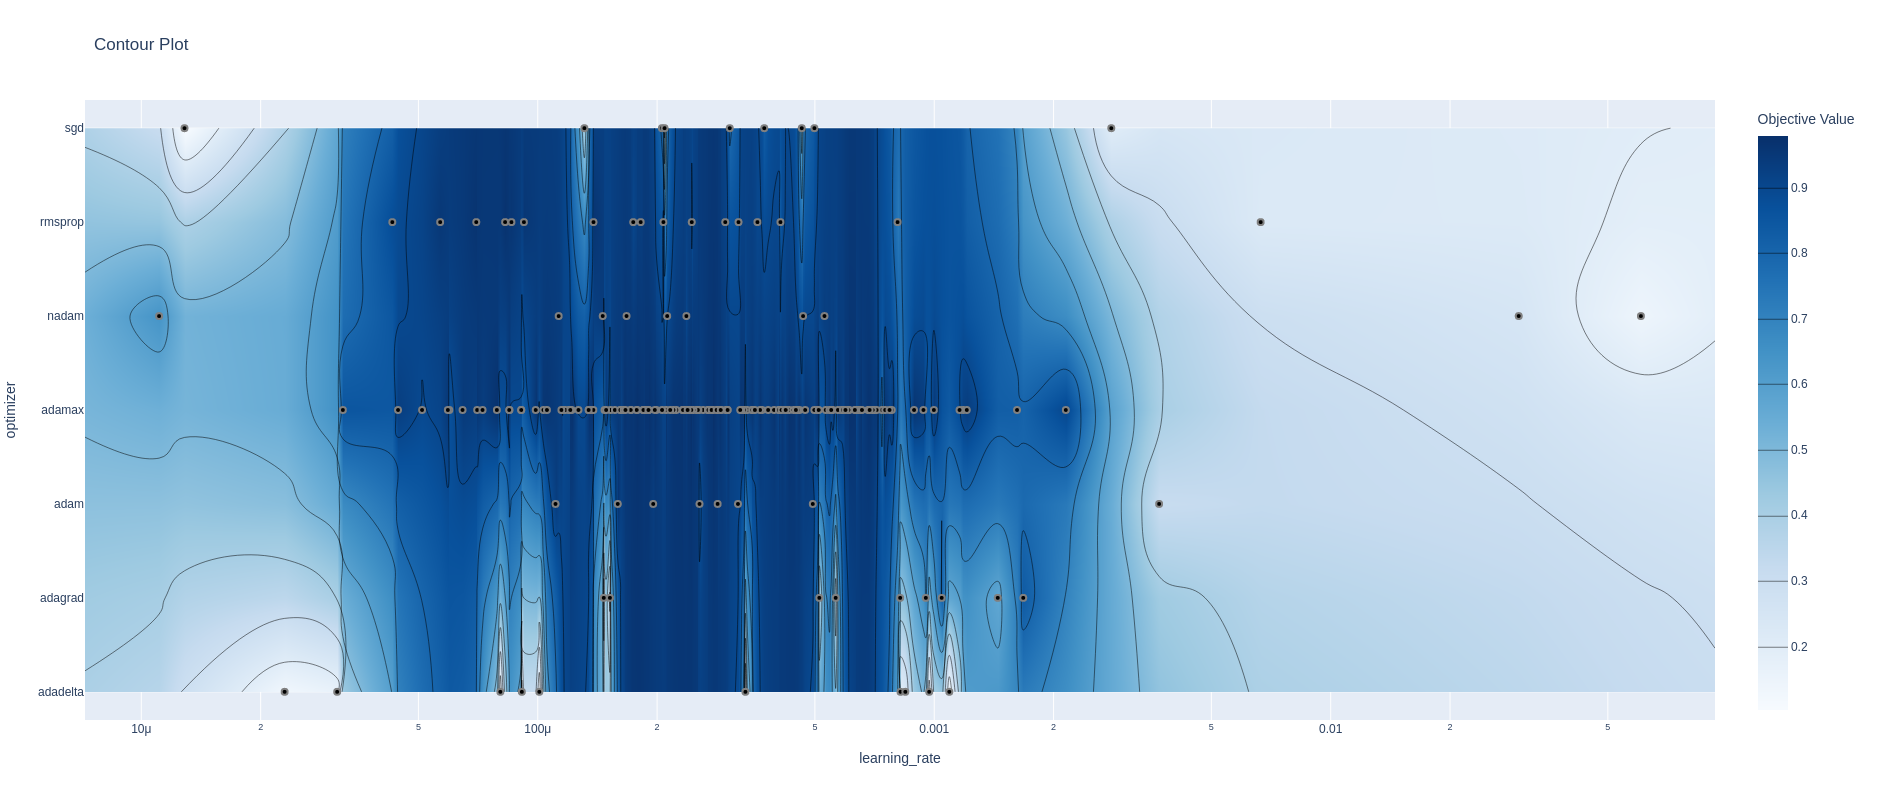

In [17]:
fig = optuna.visualization.plot_contour(study, params = ['optimizer', 'learning_rate'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.write_image('./optuna-vis/contours.png')
fig

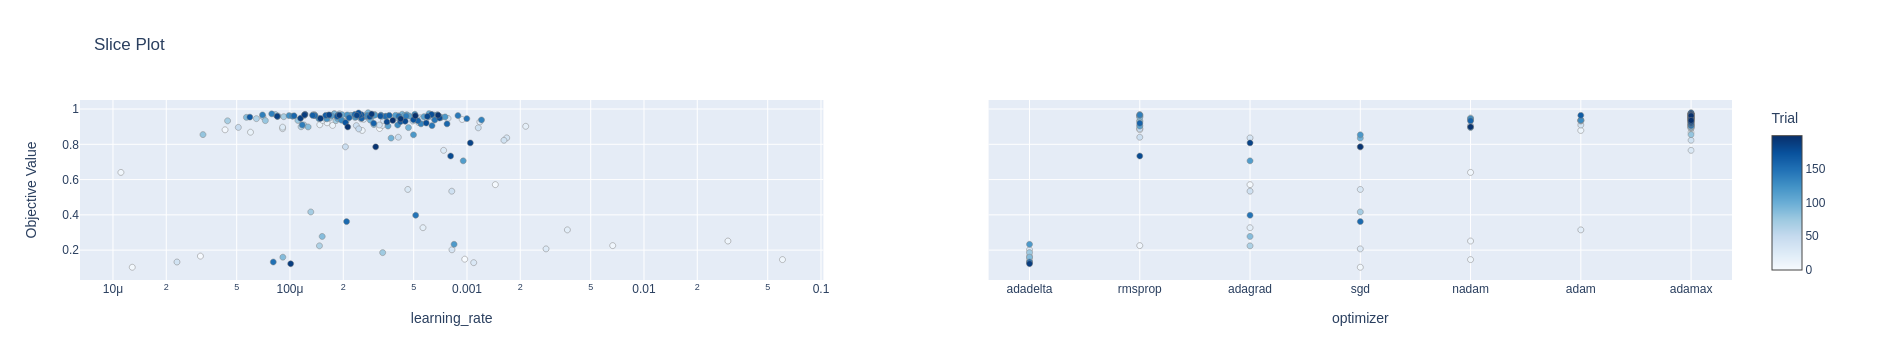

In [18]:
fig = optuna.visualization.plot_slice(study, params = ['optimizer', 'learning_rate'])
fig.write_image('./optuna-vis/slice-opt-rl.png')
fig

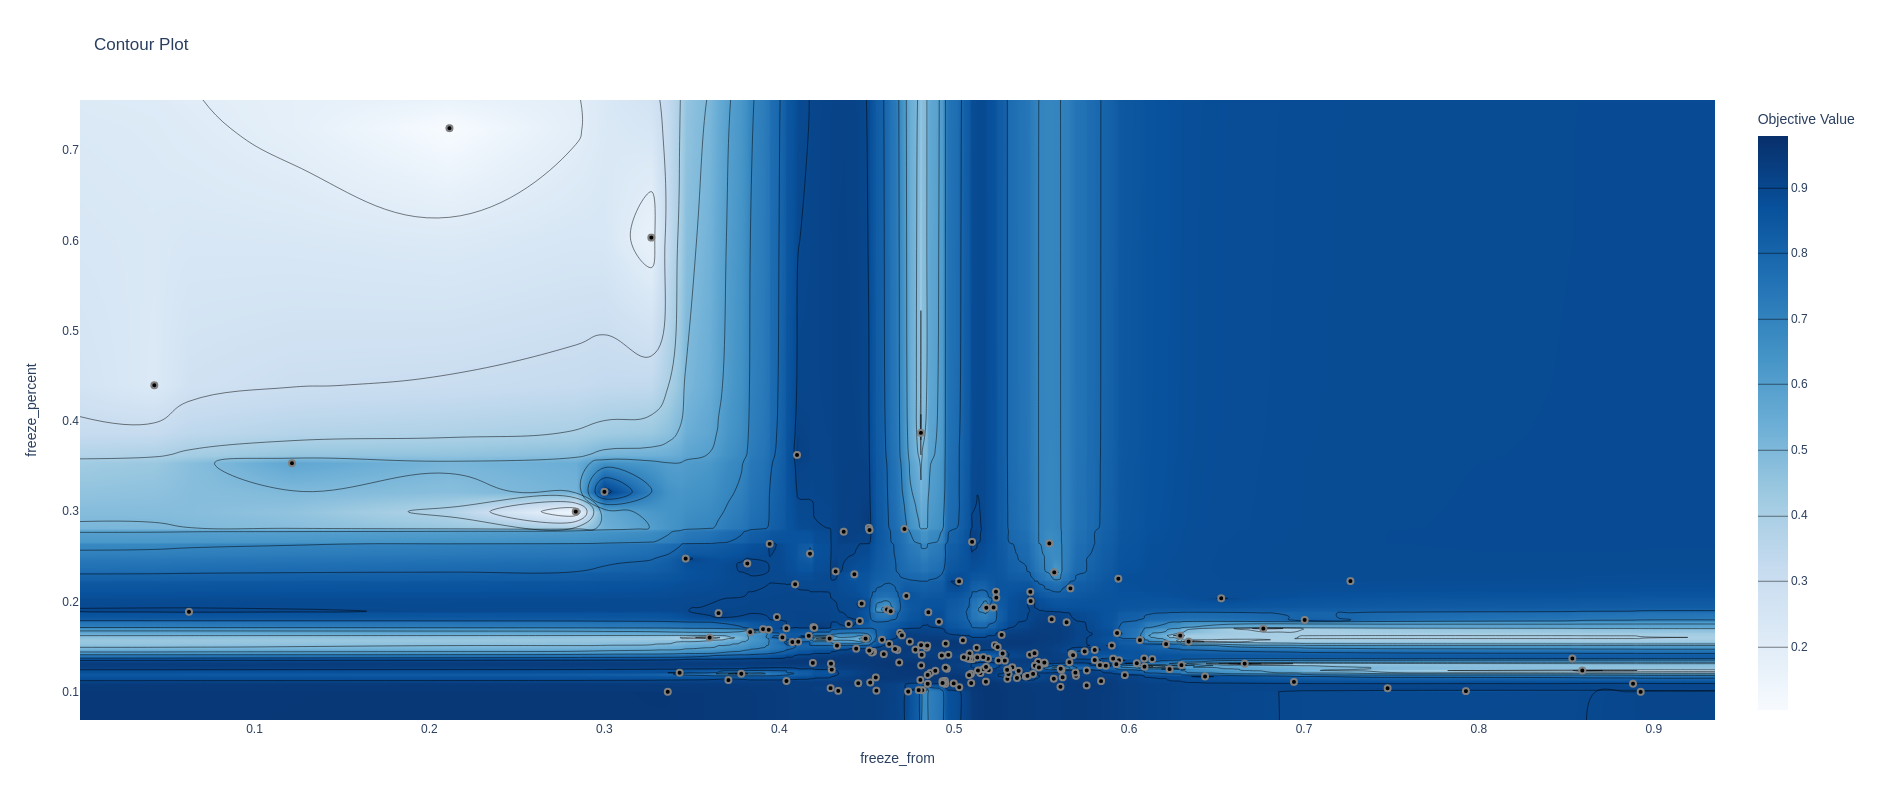

In [21]:
fig = optuna.visualization.plot_contour(study, params = ['freeze_from', 'freeze_percent'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.write_image('./optuna-vis/contours_freeze.png')
fig

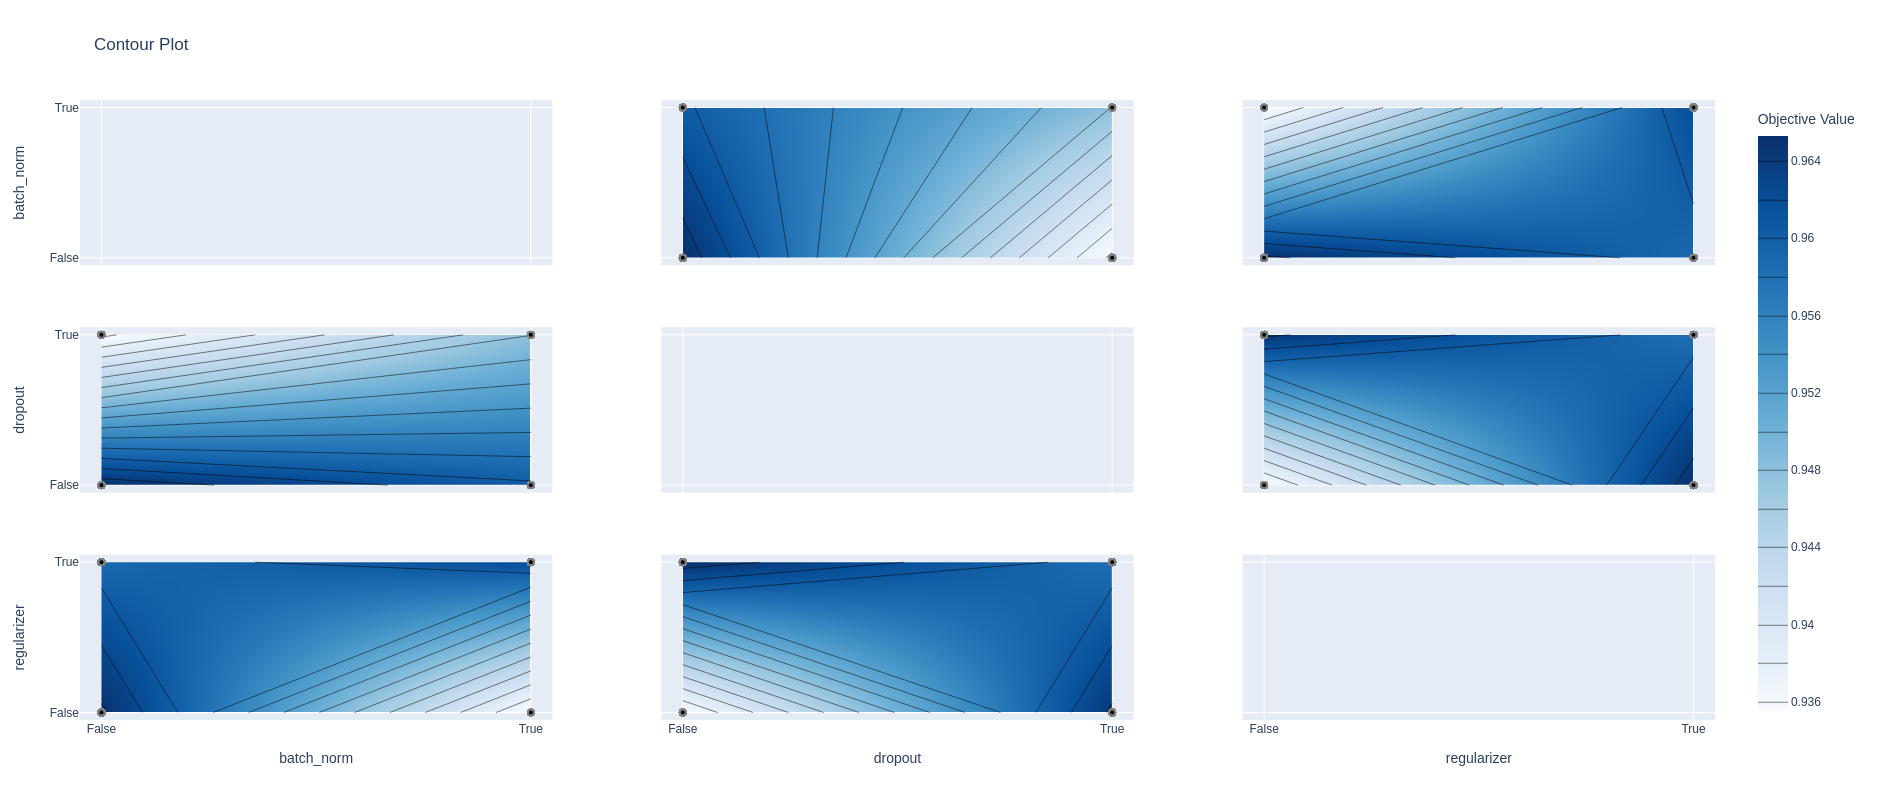

In [22]:
fig = optuna.visualization.plot_contour(study, params = ['regularizer', 'dropout', 'batch_norm'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.write_image('./optuna-vis/contours_regdrobat.png')
fig

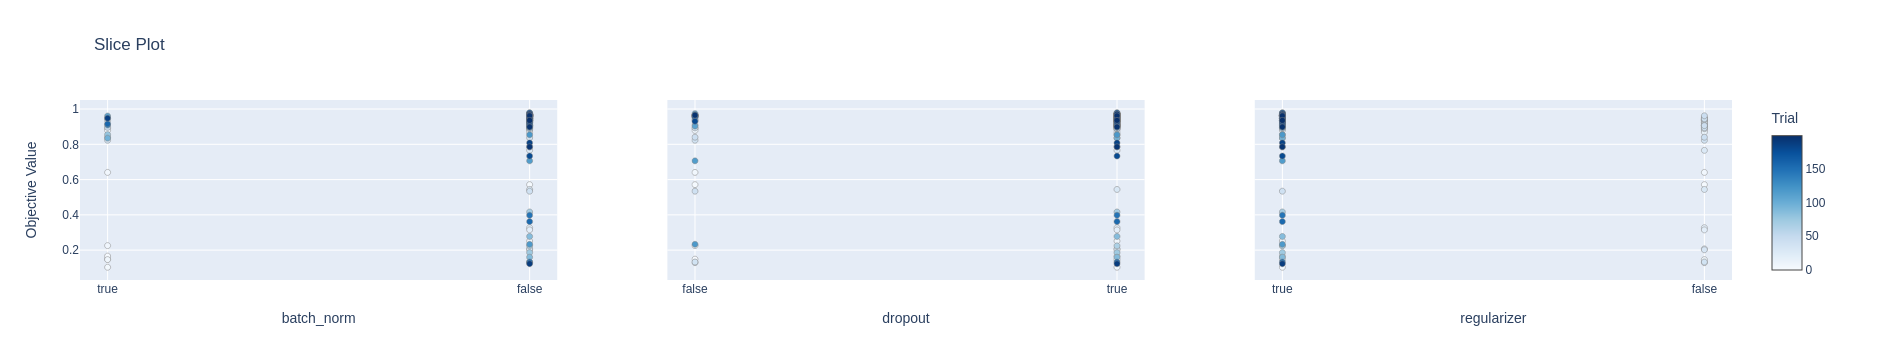

In [20]:
fig = optuna.visualization.plot_slice(study, params = ['regularizer', 'dropout', 'batch_norm'])
fig.write_image('./optuna-vis/slice-regdrobat.png')
fig

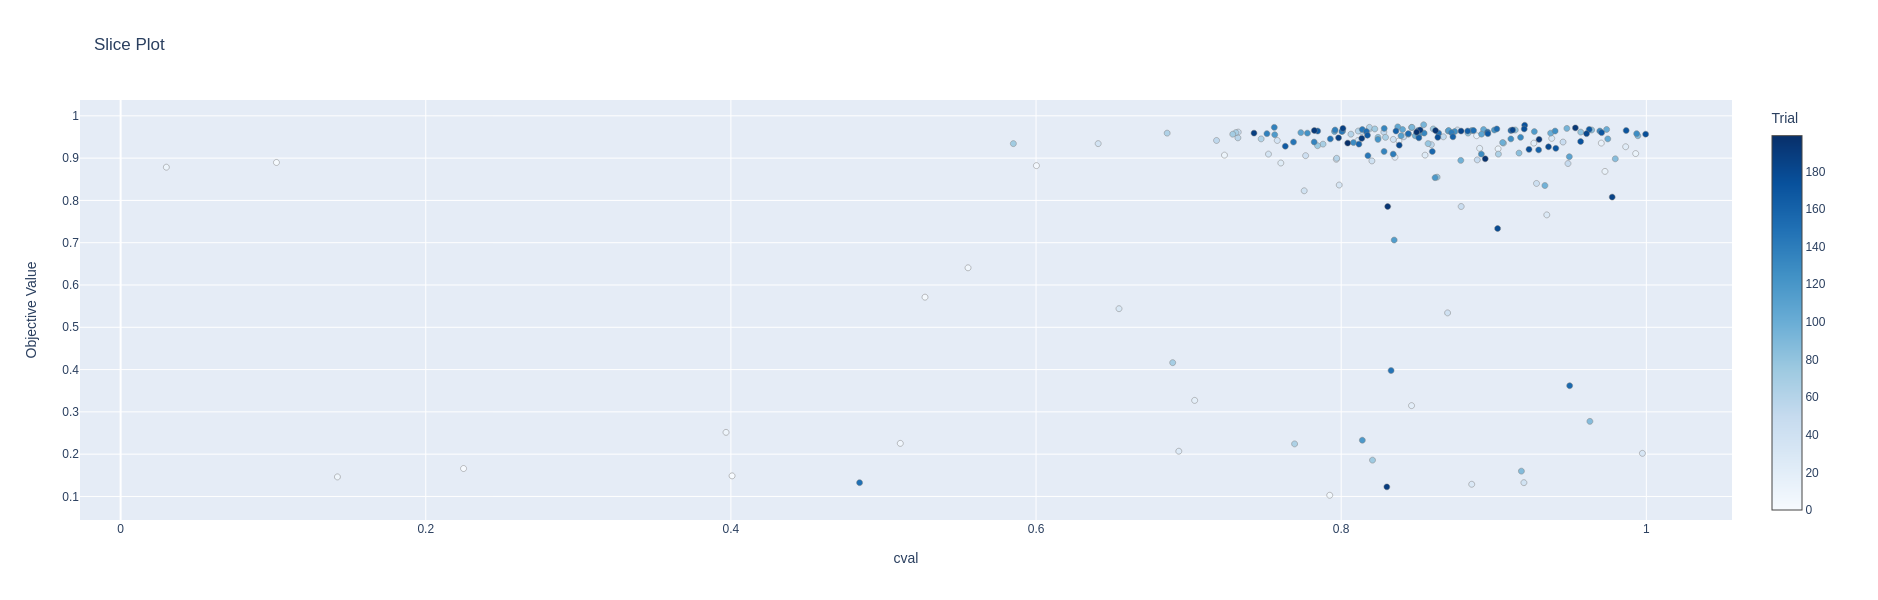

In [25]:
fig = optuna.visualization.plot_slice(study, params = ['cval'])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,)
fig.write_image('./optuna-vis/slice-cval.png')
fig

## Qualitative analysis

In [71]:
import numpy as np
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from src.model import build_model_tricks # Aquí hauràs d'importar la funció del model que facis servir

data_dir = './data/MIT_split/test'
batch_size = 32
image_size = (224, 224)

# create an ImageDataGenerator for the test data
prep = keras.applications.xception.preprocess_input
test_datagen = ImageDataGenerator(preprocessing_function=prep)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    classes=['coast', 'forest', 'highway', 'inside_city',
                'mountain', 'Opencountry', 'street', 'tallbuilding']
)

# Load report with best params
# with open("report_best_model.txt", 'r') as f:
#     lines = f.readlines()

# Get best params
# best_params = {}
# for line in lines[3:]:
#     key, value = line.split(': ')
#     best_params[key] = value.strip()
    
# model = build_model_tricks(
#         dropout=best_params['dropout'] == 'True',
#         batch_norm=best_params['batch_norm'] == 'True',
#         regularizer=best_params['regularizer'] == 'True',
#         freeze_from=float(best_params['freeze_from']),
#         freeze_percent=float(best_params['freeze_percent']),
#     )
# model.load_weights('./out/model_weights/xception_best_model.h5')

model = load_model('./out/model_weights/xception_best_model.h5')

Found 807 images belonging to 8 classes.


In [72]:
# make predictions on the test data
predictions = model.predict(test_generator)



26/26 [==============================] - 6s 181ms/step


In [73]:
# Check that the accuracy is the same as the one in the report
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)
acc = np.sum(y_true == y_pred) / len(y_true)
print(f'Accuracy: {acc}')

Accuracy: 0.9690210656753407


In [78]:
def plot_predictions(predictions, images, labels, classes, class_names, n=10, only_correct=False, only_incorrect=False, class_index=0):
    # get the number of rows needed to plot all images
    rows = (n + 4) // 5
    # create a figure and axis
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    # flatten the axis array
    axes = axes.ravel()

    if class_index is not None:
        correct_indices = np.where((np.argmax(predictions, axis=-1) == np.argmax(labels, axis=-1)) & (classes == class_index))[0]
        incorrect_indices = np.where((np.argmax(predictions, axis=-1) != np.argmax(labels, axis=-1)) & (classes == class_index))[0]
    else:
        correct_indices = np.where(np.argmax(predictions, axis=-1) == np.argmax(labels, axis=-1))[0]
        incorrect_indices = np.where(np.argmax(predictions, axis=-1) != np.argmax(labels, axis=-1))[0]
    
    if only_correct:
        indices = np.random.choice(correct_indices, min(n, len(correct_indices)), replace=False)
    elif only_incorrect:
        indices = np.random.choice(incorrect_indices, min(n, len(incorrect_indices)), replace=False)
    else:
        indices = np.random.choice(range(len(images)), min(n, len(images)), replace=False)
        
    images = images[indices]
    labels = labels[indices]
    predictions = predictions[indices]
    # plot the images
    for i in range(len(indices)):
        # get the i-th image and its corresponding prediction
        img = images[i].astype(np.uint8)
        prediction = np.argmax(predictions[i])

        # plot the image on the i-th subplot
        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {class_names[prediction]}\nActual: {class_names[np.argmax(labels[i])]}')
        axes[i].axis('off')

    # remove the remaining subplots
    for i in range(len(indices), len(axes)):
        axes[i].remove()

    plt.show()

    return indices


In [75]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    data_dir,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

images, labels = [], []

for data, label in test_generator:
    images.append(data)
    labels.append(label)

    if len(images) == len(predictions):
        break

Found 807 images belonging to 8 classes.


In [76]:
# concatenate the batches of images and labels
images_concat = np.concatenate(images)
labels_concat = np.concatenate(labels)
classes = test_generator.classes[:len(predictions)]
class_names = list(test_generator.class_indices.keys())

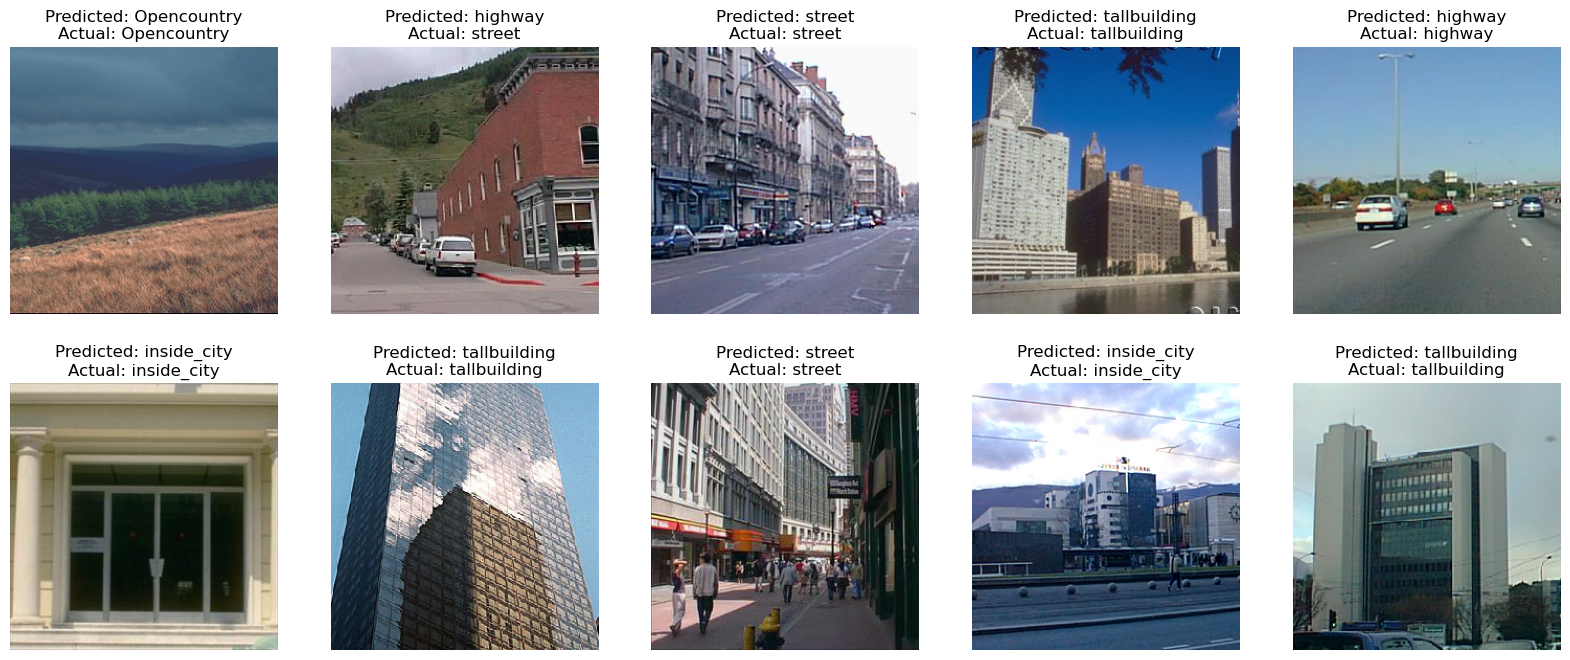

array([ 34, 682, 654, 730, 346, 412, 725, 634, 466, 780])

In [92]:
indices = plot_predictions(predictions, images_concat, labels_concat, classes, class_names, n=10, only_incorrect=False, class_index=None)
indices

## Layer analysis

In [104]:
from math import ceil
from keras.layers import Conv2D
from keras.models import Model

def get_intermediate_layer_model(model, layer_index: int = -1) -> Model:
    """
    Returns the intermediate layers model from a given model. 

    Args:
        model (Sequential): Keras model.
        layer_name (int): Index of the layer to be returned.
    """
    intermediate_layer_model = Model(inputs=model.input,
                                        outputs=model.layers[layer_index].output)
    return intermediate_layer_model


def visualize_layer(model, sample, conv_index=None, min_layers: int = 0, max_layers: int = -1, step: int = 1, aggr='Max'):
    conv_layers = [i for i, layer in enumerate(model.layers) if 'conv' in layer.name][min_layers:max_layers]

    if conv_index is not None:
        if conv_index < 0:
            conv_index = len(conv_layers) + conv_index
        feature_model = get_intermediate_layer_model(model, conv_layers[conv_index])
        feature_maps = feature_model.predict(sample)
        feature_maps = feature_maps[0]

        if aggr == 'Max':
            layer_output = np.max(feature_maps, axis=-1)
        elif aggr == 'Avg':
            layer_output = np.average(feature_maps, axis=-1)
        elif aggr == 'Sum':
            layer_output = np.sum(feature_maps, axis=-1)
        else:
            raise ValueError('Invalid aggregation method')

        plt.figure(figsize=(4, 4))
        plt.imshow(layer_output)
    else:
        num_rows = ceil(len(conv_layers) / 5)
        plt.figure(figsize=(8, 2*num_rows))
        
        for i in range(0, len(conv_layers), step):
            layer_index = conv_layers[i]
            feature_model = get_intermediate_layer_model(model, layer_index)
            feature_maps = feature_model.predict(sample)
            feature_maps = feature_maps[0]
            if aggr == 'Max':
                layer_output = np.max(feature_maps, axis=-1)
            elif aggr == 'Avg':
                layer_output = np.average(feature_maps, axis=-1)
            elif aggr == 'Sum':
                layer_output = np.sum(feature_maps, axis=-1)
            else:
                raise ValueError('Invalid aggregation method')

            plt.subplot(num_rows, 5, int(i/10)+1)
            plt.imshow(layer_output)
            plt.axis('off')
            plt.title(f'Layer {layer_index}')

1/1 [==============================] - 1s 1s/step


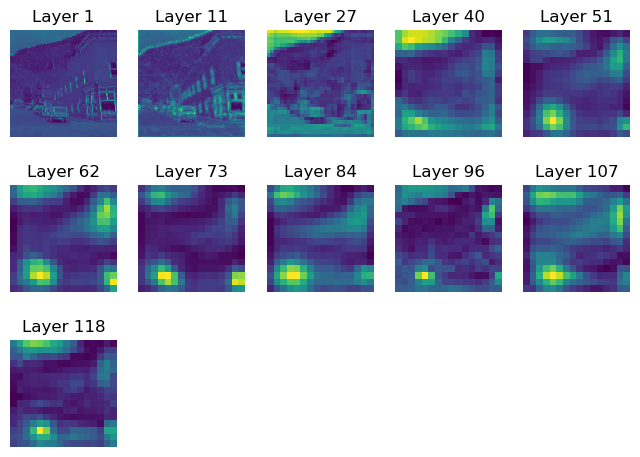

In [105]:
sample = images_concat[346][None, ...]
# 110 convnets
visualize_layer(model, sample, conv_index=None, step=10, aggr="Max")